## EDA: game ratings data 

### Springboard Capstone 2 project: building a recommendation engine
### John Burt


### Purpose of this notebook:

Explore the user ratings data. Is there anything unusual about the distribution of ratings?

#### The method:

- Load user-game ratings data into a pandas dataframe from provided csv files.

- Use pivot to convert the data into a games(rows) X users(cols) rating matrix, with NaNs where users haven't rated games (majority of cells).

- Analyze ratings by user and game


In [29]:
from IPython.display import HTML

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

## Load ratings and game ID data from csv files


In [8]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---

%matplotlib inline
import pandas as pd
pd.options.display.max_columns = 100
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np

from datetime import datetime

pd.options.display.max_rows = 100

srcdir = './data/'

# load the boardgame user ratings data
userdata = pd.read_csv(srcdir+'bgg_user_ratings.csv', 
                       encoding = "ISO-8859-1") 
userdata=userdata.rename(columns = {'username':'userID', 
                                    'gameid':'gameID'})
userdata = userdata.drop_duplicates(subset=['gameID','userID'])

# load the boardgame metadata
gameinfo = pd.read_csv(srcdir+'bgg_game_info.csv')

print('number of ratings =',userdata.shape[0])
print('number of users =',len(userdata['userID'].unique()))
print('number of games =',gameinfo.shape[0])

userdata.head()

number of ratings = 15687808
number of users = 301760
number of games = 12600


,gameID,userID,rating
0,13,sidehacker,10.0
1,13,Varthlokkur,10.0
2,13,dougthonus,10.0
3,13,cypar7,10.0
4,13,ssmooth,10.0


### User rating frequency histogram.

How many games do users rate, and what is the distribution of average user rating?

#### Hmmm.... There's something odd going on in the rating count histogram: there's an extra distribution of users rating > 4200 games. 


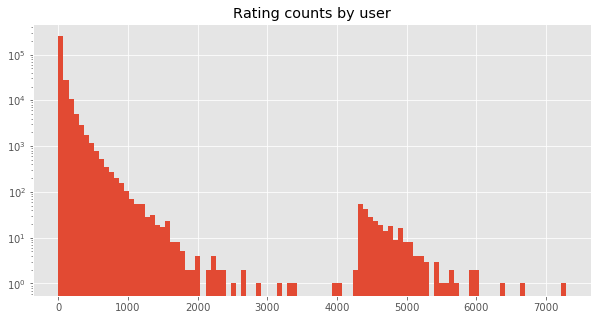

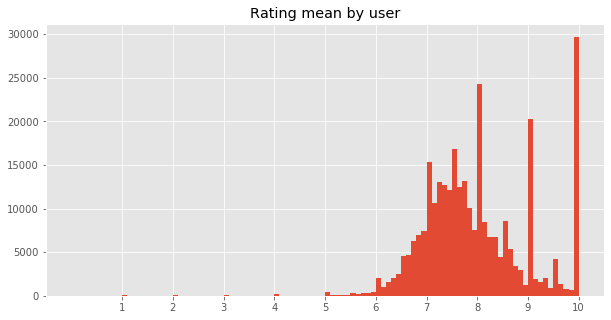

In [9]:
usergp = userdata.groupby('userID')

plt.figure(figsize=(10,5))
plt.hist(usergp['rating'].count(), bins=100)
plt.yscale('log')
# plt.xscale('log')
plt.title('Rating counts by user');

plt.figure(figsize=(10,5))
plt.hist(usergp['rating'].mean(), bins=100)
plt.xticks([1,2,3,4,5,6,7,8,9,10])
# plt.yscale('log')
plt.title('Rating mean by user');


### Game rating frequency histogram.

How many ratings do games receive, and what's the distribution of average game ratings?

#### Hmmm... There's something odd with the mean game rating frequencies: where I'd expect a single distribution, there are two, one centered at ~4.75 and another at ~7.

(12600,)


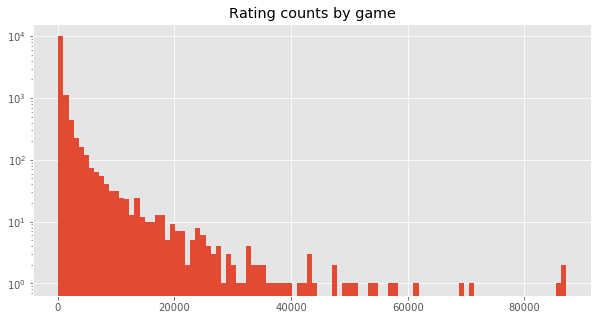

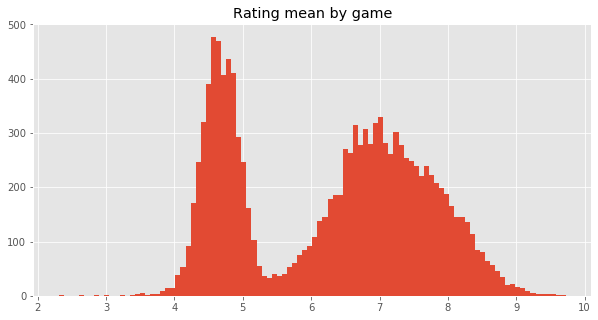

In [10]:
gamegp = userdata.groupby('gameID')

plt.figure(figsize=(10,5))
plt.hist(gamegp['rating'].count(), bins=100)
plt.yscale('log')
plt.title('Rating counts by game');

plt.figure(figsize=(10,5))
plt.hist(gamegp['rating'].mean(), bins=100)
# plt.yscale('log')
plt.title('Rating mean by game');

print(gamegp['rating'].mean().shape)

### Looking further at the mean game rating distributions

The mean game rating histogram shows two distributions: one at about 4.75, and the other at about 7.0.

How do these different groupings differ?

Since they have little overlap, I can can split them up using a rating threshold.

#### Looking at rating counts for games below vs. above threshold, I see that the below threshold games have a lot fewer ratings.

games_below.shape (4546, 2)
games_above.shape (8054, 2)


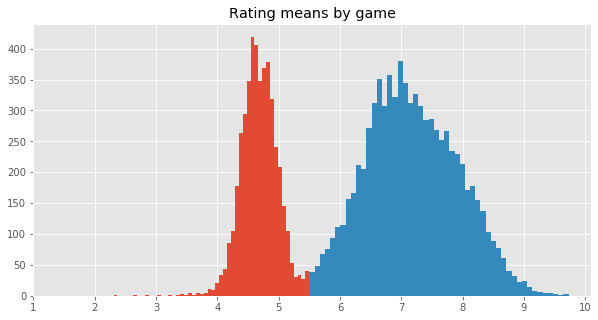

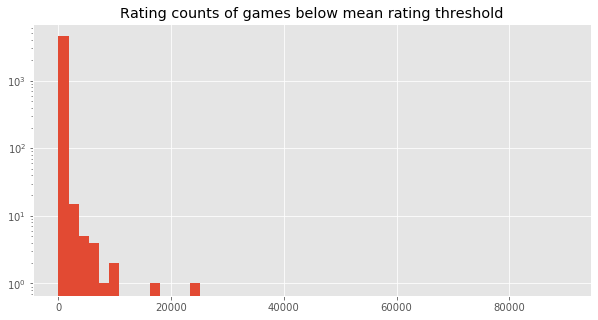

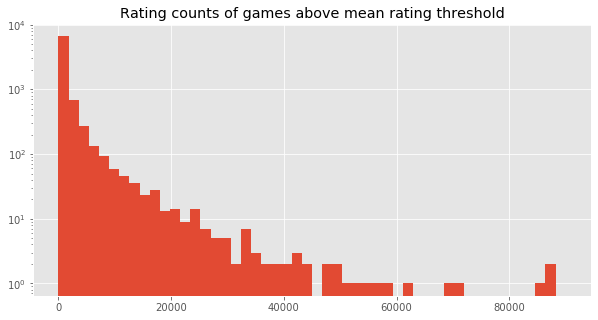

In [11]:
# rating threshold to split the distributions
max_rating = 5.5

# convert game mean rating grouping to dataframe
gm = gamegp.mean().reset_index()

# split user grouped data by # ratings per user
games_above = gm[gm['rating']>max_rating]
games_below = gm[gm['rating']<=max_rating]

print('games_below.shape',games_below.shape)
print('games_above.shape',games_above.shape)

# show histo by # user ratings - should be split at max_count threshold
plt.figure(figsize=(10,5))
plt.hist(games_below['rating'], bins=50)
plt.hist(games_above['rating'], bins=50)
plt.xticks([1,2,3,4,5,6,7,8,9,10])
# plt.yscale('log')
plt.title('Rating means by game');

# convert user grouping count to dataframe
gc = gamegp.count().reset_index().set_index('gameID')

# show histo by mean user ratings 
plt.figure(figsize=(10,5))
plt.hist(gc.loc[games_below['gameID']]['rating'], bins=50, range=[1,90000])
plt.yscale('log')
plt.title('Rating counts of games below mean rating threshold');

plt.figure(figsize=(10,5))
plt.hist(gc.loc[games_above['gameID']]['rating'], bins=50, range=[1,90000]);
# plt.xticks([1,2,3,4,5,6,7,8,9,10])
plt.yscale('log')
plt.title('Rating counts of games above mean rating threshold');


### Boardgamegeek mean game rating metadata

Helpfully, Boardgamegeek includes in its metadata their own measure of average game rating for all games. I have this as a feature column in the gameinfo dataframe.

What does the BGG mean game rating hist look like?

#### It is a single distribution centered at about 6.8. That roughly matches the upper distribution of mean game ratings in my scraped data. 

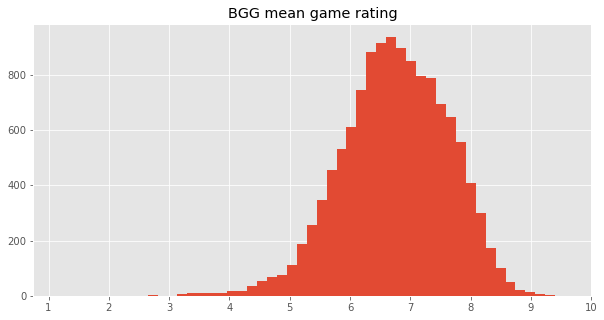

In [12]:
# histogram of BGG mean rating
plt.figure(figsize=(10,5))
plt.hist(gameinfo['mean_rating'], bins=50)
plt.xticks([1,2,3,4,5,6,7,8,9,10])
plt.title('BGG mean game rating');


### Comparing BGG mean game ratings vs. scraped mean game ratings

- First I'll add the BGG mean rating to the games I've split based on average rating threshold.
- Then I'll plot the scraped data mean game rating vs. the BGG mean game rating.


- **Prediction:** If the scraped game ratings are OK, then it should be very similar to the BGG mean rating, and then should plot out along the diagonal. Any games that deviate from the diagonal indicate that my calculated ratings are in error.

### OK, it's pretty clear that there are two distributions of games, each tightly associated with a different regression line:

- One line of points lies along the diagonal. These are games where the scraped ratings closely match the BGG mean ratings.


- #### The other line of points has a much steeper slope and a different intercept. That's really weird! 


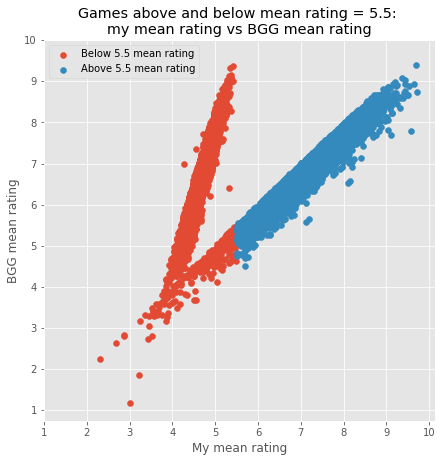

In [13]:
# add game metadata to the user rating data
gameinfo.rename(columns={'id':'gameID'}, inplace=True)
gbelow = games_below.merge(right=gameinfo, how='left', on='gameID')
gabove = games_above.merge(right=gameinfo, how='left', on='gameID')

# scatter of calcuted mean vs BGG mean rating
plt.figure(figsize=(7,7))
plt.scatter(gbelow['rating'], gbelow['mean_rating'], label='Below 5.5 mean rating')
plt.scatter(gabove['rating'], gabove['mean_rating'], label='Above 5.5 mean rating')
plt.title('Games above and below mean rating = 5.5: \nmy mean rating vs BGG mean rating')
plt.xlabel('My mean rating')
plt.ylabel('BGG mean rating')
plt.legend()
plt.yticks([1,2,3,4,5,6,7,8,9,10]);
plt.xticks([1,2,3,4,5,6,7,8,9,10]);


### Solution:

After reviewing the code I used for web scraping of ratings, I discovered a bug: after collecting ratings for all games in blocks of 250 games and 100 ratings each, the last remaining ratings are downloaded separately for each game. That is where the bugs was: it downloaded ratings for 250 games, and assigned them all to one game. This was done to only a subset of games since downloading continued between code edits.

### I fixed the code and re-scraped all game ratings:

- Most of the mean rescraped game ratings are now very close to the BGG mean ratings, and there is no second distribution. 


- However, there are a few outliers (deviations from the diagonal), which may be due to another smaller glitch in the download code (for example occasionally missing a page of ratings). I will revisit the code but this data seems good enough to use as-is.

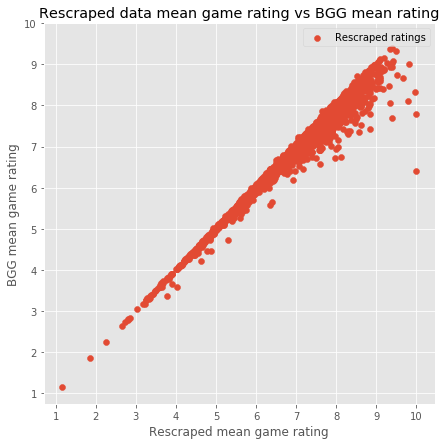

In [28]:
# load the rescraped boardgame user ratings data
rs_userdata = pd.read_csv(srcdir+'bgg_user_ratings_v2.csv', 
                       encoding = "ISO-8859-1") 
rs_userdata = rs_userdata.rename(columns = {'username':'userID', 
                                    'gameid':'gameID'})
rs_userdata = rs_userdata.drop_duplicates(subset=['gameID','userID'])

# calc game mean ratings from rescraped data
rs_gamegp = rs_userdata.groupby('gameID').mean().reset_index()

# add game metadata to the user rating data
rs_gamegp = rs_gamegp.merge(right=gameinfo, how='left', on='gameID')

# scatter of calcuted mean vs BGG mean rating
plt.figure(figsize=(7,7))
plt.scatter(rs_gamegp['rating'], rs_gamegp['mean_rating'], label='Rescraped ratings')
plt.title('Rescraped data mean game rating vs BGG mean rating')
plt.xlabel('Rescraped mean game rating')
plt.ylabel('BGG mean game rating')
plt.legend()
plt.yticks([1,2,3,4,5,6,7,8,9,10]);
plt.xticks([1,2,3,4,5,6,7,8,9,10]);
